<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.9.7.4-LSTMB128_dr20_rdr20_batch32_lr001-GloVe_with_stop_nonlemmatized-500k-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained GloVe embedding using LSTM with 500k samples without removing stop words

For this notebookw, we will train 500k total samples with the following LSTM architectuure

* Glove embedding with 300 dimension vectors
* max sequence length of 100 words (this is same as what we've been doing)
* 128 LSTM cells 
* dropout rate: 0.2
* recurrent dropout rate: 0.2
* learning rate: 0.001
* batch size of 32
* epochs: 20
* patience: 4



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/device:GPU:0'

In [2]:
# check what GPU we got
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# check that we are using high RAM runtime
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Tue May  5 15:25:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    33W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from datetime import datetime


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 128 # total LSTM units
# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
RECURRENT_DROPOUT_RATE = 0.2
PATIENCE = 4


# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100


MODEL_NAME = f"LSTMB{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, Dropout {DROPOUT_RATE}, Recurrent Dropout {RECURRENT_DROPOUT_RATE}, Batch Size {BATCH_SIZE}, Learning Rate {LEARNING_RATE}"
FEATURE_SET_NAME = "glove_with_stop_nonlemmatized"

SAMPLES = "500k"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename('LSTM128_dr20_rdr20_batch32_lr001-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv')


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'




start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [5]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=80202
Number of Documents=374123
Train review vectors shape: (374123, 100)  Test review vectors shape: (124708, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [6]:

EMBEDDING_INDEX_FILE = f'{DRIVE_DIR}/models/glove.840B.300d-embedding_index'

embeddings_index = {}

if os.path.exists(f'{EMBEDDING_INDEX_FILE}.npy'):
  print(f'Loading {EMBEDDING_INDEX_FILE}.npy')
  embeddings_index = np.load(f'{EMBEDDING_INDEX_FILE}.npy', 
                             allow_pickle = True).item()
else:
  print('Indexing word vectors.')

  with open(EMBEDDING_FILE) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  np.save(EMBEDDING_INDEX_FILE, embeddings_index)

print(type(embeddings_index))
print(np.shape(embeddings_index))
print('Found %s word vectors.' % len(embeddings_index))




Loading drive/My Drive/Springboard/capstone/models/glove.840B.300d-embedding_index.npy
<class 'dict'>
()
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [7]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 80203
embedding_matrix shape: (80204, 300)
Number of missing words from our vocabulary: 25805


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [9]:
vocab_size = len(t.word_index)+1

# building our network
model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
model.add(Embedding(input_dim=vocab_size,
                            output_dim=EMBED_SIZE,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
# model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(LSTM_DIM, dropout = DROPOUT_RATE, recurrent_dropout = RECURRENT_DROPOUT_RATE))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=["categorical_accuracy"])


In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          24061200  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 24,281,493
Trainable params: 220,293
Non-trainable params: 24,061,200
_________________________________________________________________
None


In [11]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
weights_dict = {i: weights[i] for i in np.arange(0, len(weights))}
print(f'class weights: {weights}')
print(f'class weights_dict: {weights_dict}')



mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     REVIEW_COLUMN,
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights_dict,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.42032118 3.02854107 2.20287929 1.20285745 0.37307351]
class weights_dict: {0: 1.420321175365166, 1: 3.028541072187481, 2: 2.2028792863609263, 3: 1.2028574528881977, 4: 0.3730735143988602}
Number of training examples: 374123
Epoch 1/20
9354/9354 [==============================] - 3782s 404ms/step - loss: 1.1278 - categorical_accuracy: 0.5941 - val_loss: 0.9418 - val_categorical_accuracy: 0.6218 - lr: 0.0010
Epoch 2/20
9354/9354 [==============================] - 3729s 399ms/step - loss: 1.0176 - categorical_accuracy: 0.6397 - val_loss: 0.8826 - val_categorical_accuracy: 0.6350 - lr: 0.0010
Epoch 3/20
9354/9354 [==============================] - 3720s 398ms/step - loss: 0.9815 - categorical_accuracy: 0.6541 - val_loss: 0.8597 - val_categorical_accuracy: 0.6478 - lr: 0.0010
Epoch 4/20
9354/9354 [==============================] - 3683s 394ms/step - loss: 0.9556 - categorical_accuracy: 0.6610 - val_loss: 0.8239 - val_categorical_accuracy: 0.6638 - lr: 0.0010
Epoch 5/20
935

Number of test: 124708
Running model.evaluate...
3898/3898 [==============================] - 126s 32ms/step - loss: 0.8182 - categorical_accuracy: 0.6684
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(124708, 5)
Getting classification report...
Accuracy: 66.84%


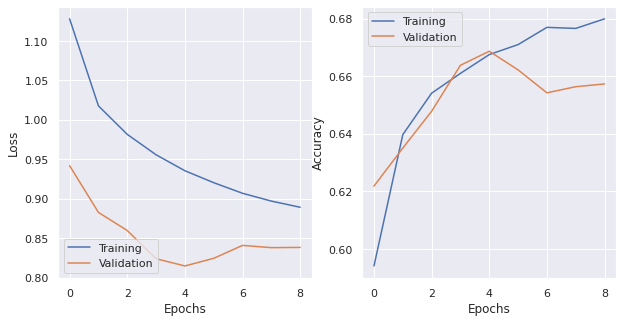


Confusion Matrix
[[11472  4569  1003   155   236]
 [ 1994  3928  1795   261   153]
 [  763  2648  5238  1929   676]
 [  264   775  3485  9522  6775]
 [  531   748  2148 10447 53193]]

Classification Report
              precision    recall  f1-score   support

           1       0.76      0.66      0.71     17435
           2       0.31      0.48      0.38      8131
           3       0.38      0.47      0.42     11254
           4       0.43      0.46      0.44     20821
           5       0.87      0.79      0.83     67067

    accuracy                           0.67    124708
   macro avg       0.55      0.57      0.56    124708
weighted avg       0.70      0.67      0.68    124708



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

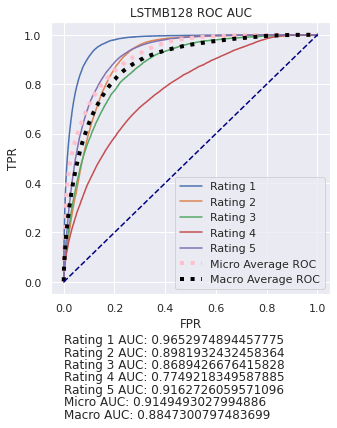

In [12]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [13]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.5511259883910701


**Save off various files**

In [14]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB128-1x128-glove_with_stop_nonlemmatized-sampling_none-498831-100-review_body
Saving to report file: drive/My Drive/Springboard/capstone/reports/LSTM128_dr20_rdr20_batch32_lr001-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv
{'model_name': 'LSTMB128', 'architecture': '1x128', 'description': '1 Layer 128 LSTM Units, Dropout 0.2, Recurrent Dropout 0.2, Batch Size 32, Learning Rate 0.001', 'feature_column': '{"1": {"precision": 0.7635782747603834, "recall": 0.6579868081445368, "f1-score": 0.7068609630610925, "support": 17435}, "2": {"precision": 0.3100726239343227, "recall": 0.4830894108965687, "f1-score": 0.37771046684936777, "support": 8131}, "3": {"precision": 0.383202867803058, "recall": 0.46543451217344944, "f1-score": 0.4203346306624403, "support": 11254}, "4": {"precision": 0.42672761495025546, "recall": 0.45732673742855773, "f1-score": 0.44149762373942275, "support": 20821}, "5": {"precision": 0.8715449019382957, "recall": 0.7931322408934349, "f1-

# Test That Our Models Saved Correctly

In [15]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


3898/3898 [==============================] - 121s 31ms/step - loss: 0.8182 - categorical_accuracy: 0.6684
Accuracy: 66.84%


In [16]:
end_time = datetime.now()
print(f"Start time: {start_time}")
print(f"End time: {end_time}")
print(f"Total Duration: {round((end_time - start_time).total_seconds() / 60, 2)} mins")

Start time: 2020-05-05 15:25:59.545068
End time: 2020-05-06 00:53:09.784183
Total Duration: 567.17 mins
